Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/14/lenet_torch.ipynb

<a href="https://colab.research.google.com/github/codeboy5/probml-notebooks/blob/add-lenet-jax/notebooks-d2l/lenet_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The LeNet CNN

Based on sec 6.5 of http://d2l.ai/chapter_convolutional-neural-networks/lenet.html

In [ ]:
import jax
import jax.numpy as jnp  # JAX NumPy
import matplotlib.pyplot as plt
import math
from IPython import display

try:
    from flax import linen as nn  # The Linen API
except ModuleNotFoundError:
    %pip install -qq flax
    from flax import linen as nn  # The Linen API
from flax.training import train_state  # Useful dataclass to keep train state

import numpy as np  # Ordinary NumPy

try:
    import optax  # Optimizers
except ModuleNotFoundError:
    %pip install -qq optax
    import optax  # Optimizers
try:
    import tensorflow_datasets as tfds  # TFDS for MNIST
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds  # TFDS for MNIST

import random
import os
import time

rng = jax.random.PRNGKey(0)
!mkdir figures # for saving plots

mkdir: cannot create directory ‘figures’: File exists


# Make the model
We hard-code the assumption that the input will be 1x28x28,
as is the case for (Fashion) MNIST.

In [ ]:
class Reshape(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = jnp.reshape(x, (-1, 28, 28, 1))
        return x


class CNN(nn.Module):
    def setup(self):
        self.reshape = Reshape()

    @nn.compact
    def __call__(self, x):
        x = nn.Conv(features=6, kernel_size=(5, 5), padding=[(2, 2), (2, 2)])(x)
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding=[(0, 0), (0, 0)])
        x = nn.Conv(features=16, kernel_size=(5, 5), padding=[(0, 0), (0, 0)])(x)
        x = nn.sigmoid(x)
        x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2), padding=[(0, 0), (0, 0)])
        x = x.reshape((x.shape[0], -1))
        x = nn.Dense(features=120)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(features=84)(x)
        x = nn.sigmoid(x)
        x = nn.Dense(features=10)(x)
        return x

In [ ]:
def compute_metrics(*, logits, labels):
    one_hot = jax.nn.one_hot(labels, num_classes=10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    metrics = {
        "loss": loss,
        "accuracy": accuracy,
    }
    return metrics

In [ ]:
def create_train_state(rng, learning_rate, momentum):
    """Creates initial `TrainState`."""
    cnn = CNN()
    params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))["params"]
    tx = optax.sgd(learning_rate, momentum)
    return train_state.TrainState.create(apply_fn=cnn.apply, params=params, tx=tx)

In [ ]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""

    def loss_fn(params):
        logits = CNN().apply({"params": params}, batch["image"])
        one_hot = jax.nn.one_hot(batch["label"], num_classes=10)
        loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (_, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    metrics = compute_metrics(logits=logits, labels=batch["label"])
    return state, metrics

In [ ]:
@jax.jit
def eval_step(params, batch):
    logits = CNN().apply({"params": params}, batch["image"])
    return compute_metrics(logits=logits, labels=batch["label"])

In [ ]:
def train_epoch(state, train_ds, batch_size, epoch, rng, animator):
    """Train for a single epoch."""
    train_ds_size = len(train_ds["image"])
    steps_per_epoch = train_ds_size // batch_size

    perms = jax.random.permutation(rng, train_ds_size)
    perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
    perms = perms.reshape((steps_per_epoch, batch_size))
    batch_metrics = []
    for perm in perms:
        batch = {k: v[perm, ...] for k, v in train_ds.items()}
        state, metrics = train_step(state, batch)
        batch_metrics.append(metrics)

    # compute mean of metrics across each batch in epoch.
    batch_metrics_np = jax.device_get(batch_metrics)
    epoch_metrics_np = {k: np.mean([metrics[k] for metrics in batch_metrics_np]) for k in batch_metrics_np[0]}

    animator.add(epoch, (epoch_metrics_np["loss"], epoch_metrics_np["accuracy"], None))
    print(
        "train epoch: %d, loss: %.4f, accuracy: %.2f"
        % (epoch, epoch_metrics_np["loss"], epoch_metrics_np["accuracy"] * 100)
    )

    return state

In [ ]:
def eval_model(params, test_ds):
    metrics = eval_step(params, test_ds)
    metrics = jax.device_get(metrics)
    summary = jax.tree_map(lambda x: x.item(), metrics)
    return summary["loss"], summary["accuracy"]

# Data

In [ ]:
def get_datasets():
    """Load MNIST train and test datasets into memory."""
    ds_builder = tfds.builder("fashion_mnist")
    ds_builder.download_and_prepare()
    train_ds = tfds.as_numpy(ds_builder.as_dataset(split="train", batch_size=-1))
    test_ds = tfds.as_numpy(ds_builder.as_dataset(split="test", batch_size=-1))
    train_ds["image"] = jnp.float32(train_ds["image"]) / 255.0
    test_ds["image"] = jnp.float32(test_ds["image"]) / 255.0
    return train_ds, test_ds

# Plotting

In [ ]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

# Training and Evaluation

In [ ]:
train_ds, test_ds = get_datasets()

In [ ]:
rng, init_rng = jax.random.split(rng)

In [ ]:
learning_rate = 0.1
momentum = 0.9

In [ ]:
state = create_train_state(init_rng, learning_rate, momentum)
del init_rng  # Must not be used anymore.

In [ ]:
num_epochs = 10
batch_size = 256

 test epoch: 10, loss: 0.44, accuracy: 84.04


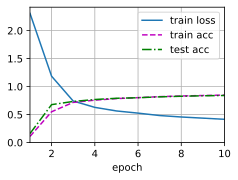

In [ ]:
animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])
for epoch in range(1, num_epochs + 1):
    # Use a separate PRNG key to permute image data during shuffling
    rng, input_rng = jax.random.split(rng)
    # Run an optimization step over a training batch
    state = train_epoch(state, train_ds, batch_size, epoch, input_rng, animator)
    # Evaluate on the test set after each training epoch
    test_loss, test_accuracy = eval_model(state.params, test_ds)
    animator.add(epoch, (None, None, test_accuracy))
    print(" test epoch: %d, loss: %.2f, accuracy: %.2f" % (epoch, test_loss, test_accuracy * 100))